House Price Predictions - Regresion

Modules

In [9]:
# Manipulation
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm
from xgboost import XGBRegressor
import joblib
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Configuration
import warnings
warnings.filterwarnings("ignore")

#Seed
import random
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

#### Data Manipulation & Feature Engineering

In [10]:
data = pd.read_csv('../Data/train.csv')
data.drop(columns='Id', inplace=True)
data.shape

(1460, 80)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

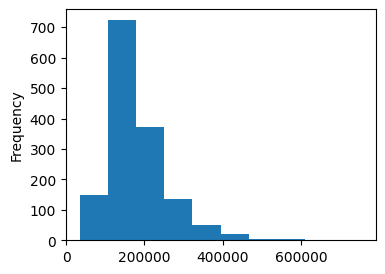

In [11]:
# Target
data.SalePrice.plot.hist(figsize = (4,3))
data.SalePrice.describe()

Missing values

In [12]:
data.isna().sum().sort_values(ascending=False)[:13]#/data.shape[0]*100

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
                ... 
GarageType        81
GarageFinish      81
GarageCond        81
GarageYrBlt       81
BsmtExposure      38
Length: 13, dtype: int64

In [13]:
quality = {'Ex':5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1, 'No': 0}

# Pool1QC
data.PoolQC[~data.PoolQC.isna()] = 'Yes'
data.PoolQC.fillna('No', inplace=True)

# MiscFeature
data.MiscFeature[~data.MiscFeature.isna()] = 'Yes'
data.MiscFeature.fillna('No', inplace=True)

# Alley
data.Alley[~data.Alley.isna()] = 'Access'
data.Alley[data.Alley.isna()] = 'No alley access'

# Fence
data.Fence[~data.Fence.isna()] = 'Yes'
data.Fence.fillna('No', inplace=True)

# FireplaceQu
#data.FireplaceQu[~data.FireplaceQu.isna()] = 'Yes'
data.FireplaceQu.fillna('No', inplace=True)
#data.FireplaceQu = data.FireplaceQu.map(quality)

# LotFrontage
lotshape_medians = data.groupby("LotShape")["LotFrontage"].mean()
data["LotFrontage"] = data["LotFrontage"].fillna(data["LotShape"].map(lotshape_medians))

# GarageQual
data.GarageQual.fillna('No', inplace=True)

# Garage
data.GarageFinish.fillna('No Garage', inplace=True)
data.GarageType.fillna('No Garage', inplace=True)
data.GarageCond.fillna('No', inplace=True)

# Basement
data.BsmtExposure.fillna('No Bsmnt', inplace=True)
data.BsmtFinType2.fillna('No Bsmnt', inplace=True)
data.BsmtFinType1.fillna('No Bsmnt', inplace=True)
data.BsmtCond.fillna('No', inplace=True)
data.BsmtQual.fillna('No', inplace=True)

# MasVnrArea
data.MasVnrArea.fillna(data.MasVnrArea.median(skipna=True), inplace=True)

# Electrical
data.Electrical.fillna(data.Electrical.mode().values[0], inplace = True)

# Drop unecessary cols
data.drop(columns=['MasVnrType'], inplace=True)

New features

In [14]:
# Building Age
data['BuildingAge'] = data.YearBuilt.max(skipna=True) - data.YearBuilt + 1
data['Remodeling'] = (data['YearBuilt'] != data['YearRemodAdd'])

# Garage Age
data['GarageYrBlt'] = data.GarageYrBlt.max(skipna=True) - data.GarageYrBlt + 1

# Drop unecessary cols
data.drop(columns=['YearBuilt','YearRemodAdd','GarageYrBlt'], inplace=True)

Engineering

In [15]:
# Binary cols
binary_cols = data.apply(lambda x: pd.Series(x).nunique() == 2, axis = 0)
print(f'Number of binary cols: {binary_cols.sum()}')
binary_cols = binary_cols[binary_cols].index.tolist()
print(binary_cols)
for col in binary_cols:
    dict_col = {data[col].unique()[0]:0, data[col].unique()[1]:1}
    data[col] = data[col].map(dict_col).astype('boolean')
    
# Specific cols
#data.MSSubClass = data.MSSubClass.astype('O')
#data.MoSold = data.MoSold.astype('O')

# Quality related cols
mask = data.columns.str.contains(r'Qu', regex=True)
cols_to_map = data.loc[:, mask].columns.difference(['OverallQual','LowQualFinSF'])
data[cols_to_map] = data[cols_to_map].apply(lambda x: x.map(quality), axis=1)

data.ExterCond = data.ExterCond.map(quality)
data.BsmtCond = data.BsmtCond.map(quality)
data.GarageCond = data.GarageCond.map(quality)
data.HeatingQC = data.HeatingQC.map(quality)

# Drop unecessary cols
data.drop(columns=['YrSold','MSSubClass','MoSold'], inplace=True)

Number of binary cols: 8
['Street', 'Alley', 'Utilities', 'CentralAir', 'PoolQC', 'Fence', 'MiscFeature', 'Remodeling']


Outliers

In [16]:
# Keep only numeric features
number_cols = data.drop(columns='SalePrice').select_dtypes(include='number')
# Give the same scale across all of them
stnd = StandardScaler()
number_cols = pd.DataFrame(stnd.fit_transform(number_cols), columns=number_cols.columns)
# Compute mean values per row
mn = number_cols.apply(lambda x: x.mean(), axis = 1)
# Remove rows extreme rows
outliers = mn.index[(mn > (mn.mean() + 4*mn.std())) | (mn < (mn.mean() - 4*mn.std()))]
# Remove outliers
data.drop(index=outliers, inplace=True)

In [17]:
# Export
#data.to_excel('../Output/train_manipulated.xlsx', index=False)

#### Visualizations

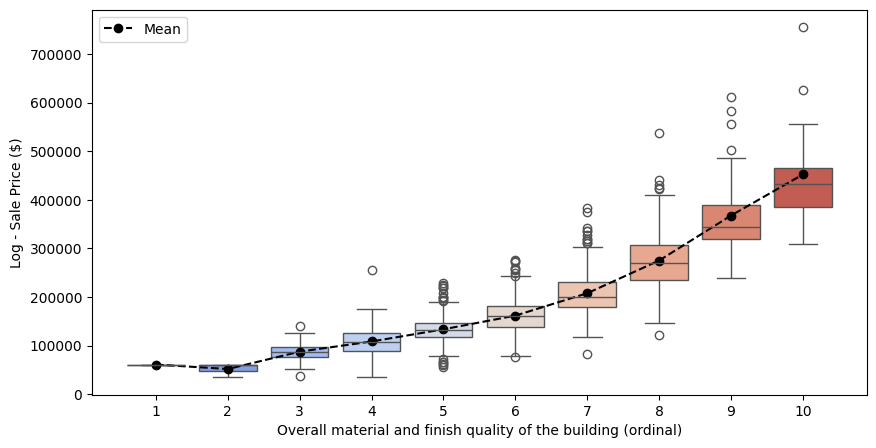

In [18]:
# Overall Quality
plt.figure(figsize=(10,5))

sns.boxplot(x='OverallQual', y='SalePrice', data=data, palette='coolwarm')
mean_prices = data.groupby('OverallQual')['SalePrice'].mean()
# Add meanline
plt.plot(np.arange(len(mean_prices)), mean_prices, color='black', marker='o', linestyle='--', label='Mean')

plt.xlabel('Overall material and finish quality of the building (ordinal)')
plt.ylabel('Log - Sale Price ($)')
plt.legend()
plt.show()

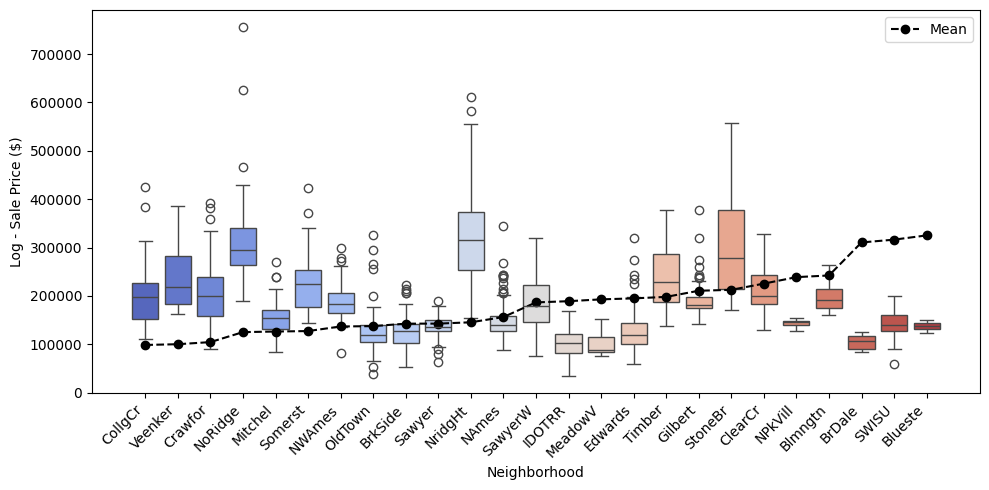

In [19]:
mean_prices = data.groupby('Neighborhood')['SalePrice'].mean().sort_values()

plt.figure(figsize=(10,5))
sns.boxplot(x='Neighborhood', y='SalePrice', data=data, palette='coolwarm')
sns.stripplot(x='Neighborhood', y='SalePrice', data=data, color='None', alpha=0.3, jitter=0.2, size=3)
plt.plot(np.arange(len(mean_prices)), mean_prices.values, color='black', marker='o', linestyle='--', label='Mean')
plt.xlabel('Neighborhood')
plt.ylabel('Log - Sale Price ($)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

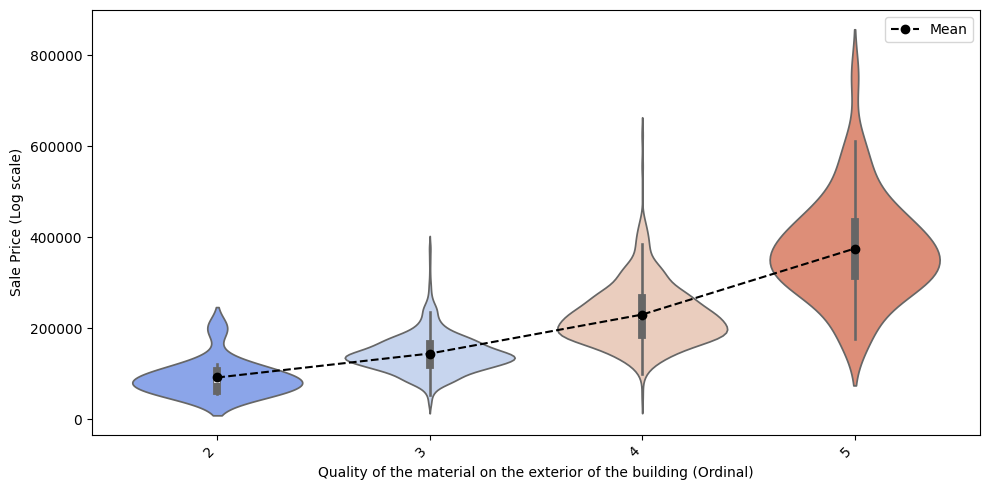

In [20]:
mean_prices = data.groupby('ExterQual')['SalePrice'].mean().sort_values()

plt.figure(figsize=(10,5))

sns.violinplot(x='ExterQual', y='SalePrice', data=data, palette='coolwarm', scale='width')

plt.plot(np.arange(len(mean_prices)), mean_prices.values, color='black', marker='o', linestyle='--', label='Mean')
plt.xlabel('Quality of the material on the exterior of the building (Ordinal)')
plt.ylabel('Sale Price (Log scale)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


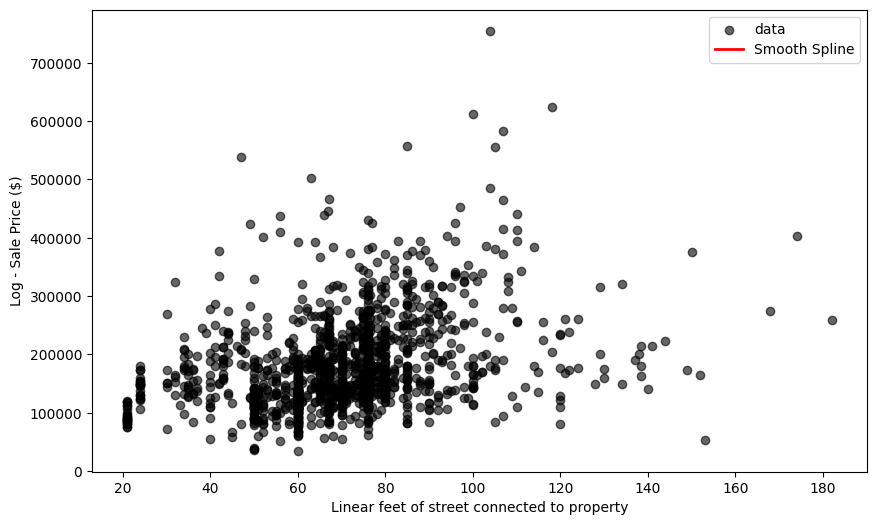

In [21]:
from scipy.interpolate import UnivariateSpline
d = data[data.LotFrontage < 300]
# data
x = d['LotFrontage'].values
y = d['SalePrice'].values

# Sort data for spline
sorted_idx = np.argsort(x)
x_sorted = x[sorted_idx]
y_sorted = y[sorted_idx]

# Fit spline
spline = UnivariateSpline(x_sorted, y_sorted, s=1e8)  # s controls smoothness
y_smooth = spline(x_sorted)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(x, y, alpha=0.6, color='black', label='data')
plt.plot(x_sorted, y_smooth, color='red', linewidth=2, label='Smooth Spline')

plt.xlabel('Linear feet of street connected to property')
plt.ylabel('Log - Sale Price ($)')
plt.legend()
plt.show()

#### Feature Selection

Univariate

In [22]:

output = {
    'Feature': []
    ,'Entropy': []
    ,'Max_entropy': []
    ,'RMSE': []
    ,'R2': []
    ,'Baseline_RMSE': []
    ,'Baseline_R2': []
    ,
    }
for col in data.drop(columns='SalePrice').columns:
    d = data[[col, 'SalePrice']].dropna()
    Xtrain, Xtest, ytrain, ytest = train_test_split(d[[col]], d.SalePrice, test_size=0.2, random_state=999)

    if not pd.api.types.is_numeric_dtype(Xtrain[col]):
        Xtrain = pd.get_dummies(Xtrain, drop_first=True)
        Xdata = pd.get_dummies(Xtest, drop_first=True)
        Xtest = Xtest.reindex(columns=Xtrain.columns, fill_value=0)
        counts = data[col].value_counts(normalize=True)
        output['Entropy'].append(entropy(counts, base=2))
        output['Max_entropy'].append(np.log2(data[col].nunique()))
    elif data[col].dtype in ['boolean', 'bool']:
        counts = data[col].value_counts(normalize=True)
        output['Entropy'].append(entropy(counts, base=2))
        output['Max_entropy'].append(np.log2(data[col].nunique()))
    else:
        output['Entropy'].append(np.nan)
        output['Max_entropy'].append(np.nan)
    
    # Model
    lr = LinearRegression()
    lr_model = lr.fit(Xtrain, ytrain)
    pred = lr_model.predict(Xtest)

    # Baseline model
    baseline_pred = np.full_like(ytest, ytrain.mean(), dtype=float)
    
    # Output
    output['Feature'].append(col)
    output['RMSE'].append(root_mean_squared_error(ytest, pred))
    output['R2'].append(r2_score(ytest, pred))
    output['Baseline_RMSE'].append(root_mean_squared_error(ytest, baseline_pred))
    output['Baseline_R2'].append(r2_score(ytest, baseline_pred))
    
output = pd.DataFrame(output).sort_values(by = 'RMSE', ascending=True).reset_index(drop=True)

In [23]:
# Remove noisy features
output = output[(output.R2 > output.Baseline_R2) & (output.RMSE < output.Baseline_RMSE)]
output = output[(output.Max_entropy/3 < output.Entropy) | output.Entropy.isna()]

# Top 5 most important features (univariate)
print(output.head(5))

       Feature  Entropy  Max_entropy          RMSE        R2  Baseline_RMSE  \
0  OverallQual      NaN          NaN  49179.177290  0.599808   77855.850767   
1    ExterQual      NaN          NaN  55330.515626  0.493435   77855.850767   
2  TotalBsmtSF      NaN          NaN  56246.554967  0.476523   77855.850767   
3    GrLivArea      NaN          NaN  58041.814582  0.442573   77855.850767   
4     1stFlrSF      NaN          NaN  59698.641687  0.410295   77855.850767   

   Baseline_R2  
0    -0.002971  
1    -0.002971  
2    -0.002971  
3    -0.002971  
4    -0.002971  


<Axes: >

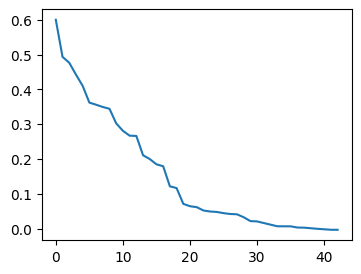

In [24]:
output.R2.plot(figsize=(4,3))

In [25]:
selected_faetures = output.Feature.tolist()
selected_faetures.append('SalePrice')

Regularization

In [26]:
# Keep selected features from revious selection
data = data[selected_faetures]
#for col in data.select_dtypes(include='O').columns:
#    data[col] = data[col].astype('category')
data = pd.get_dummies(data, drop_first=True)

In [27]:
# Split data
Xtrain, Xtest, ytrain, ytest = train_test_split(data.drop(columns = 'SalePrice'), data.SalePrice, test_size=0.15, random_state=9999)
Xtr, Xval, ytr, yval = train_test_split(Xtrain, ytrain, test_size=0.15, random_state=9999)

metrics = {
    'data': ['Train', 'test'],
    'RMSE': [],
    'R2': [],
}
xgb = XGBRegressor(
    # Base
    objective='reg:squarederror',
    booster='gbtree',
    early_stopping_rounds=1000,
    eval_metric='rmse',

    # Tree-related
    n_estimators=10**4,
    colsample_bytree=0.1,
    subsample=0.9,
    learning_rate=0.01,
    max_leaves = 14, 
    max_depth=7,
    min_child_weight = 3,
    
    # Regularization
    gamma = 4.5,
    reg_lambda = 8,
    alpha = 0.5,
    enable_categorical = True,
    
    random_state=42
).fit(
    Xtr, ytr,
    eval_set=[(Xval, yval)],
    verbose=0
)

metrics['RMSE'].append(root_mean_squared_error(ytr, xgb.predict(Xtr)))
metrics['RMSE'].append(root_mean_squared_error(ytest, xgb.predict(Xtest)))
metrics['R2'].append(r2_score(ytr, xgb.predict(Xtr)))
metrics['R2'].append(r2_score(ytest, xgb.predict(Xtest)))
metrics = pd.DataFrame(metrics)
metrics

,data,RMSE,R2
0,Train,14624.523438,0.965973
1,test,21561.587891,0.910207


Selected features: N = 43


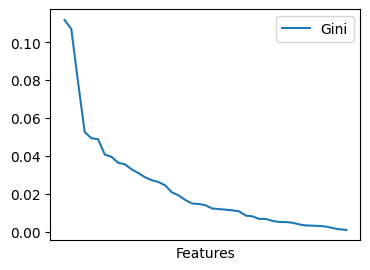

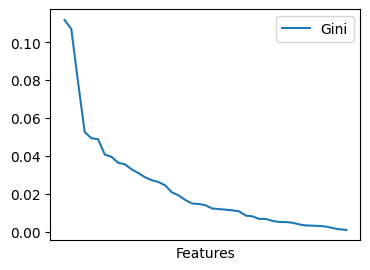

In [28]:
importance = pd.DataFrame({'Features': xgb.get_booster().feature_names, 'Gini':xgb.feature_importances_}).sort_values(by = 'Gini', ascending=False)
importance.plot(x = 'Features', y = 'Gini', figsize=(4, 3)).set_xticks([])
keep = importance.head(50)
keep.plot(x = 'Features', y = 'Gini', figsize=(4, 3)).set_xticks([])
print(f'Selected features: N = {keep.shape[0]}')

#### Tuning

In [29]:
# Split data
Xtrain, Xtest, ytrain, ytest = train_test_split(data[keep.Features], data.SalePrice, test_size=0.15, random_state=9999)
Xtr, Xval, ytr, yval = train_test_split(Xtrain, ytrain, test_size=0.15, random_state=9999)

In [30]:
# Bayesian hyperparameter optimization

# 1. Define search space
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),  # continuous
    'max_depth': hp.choice('max_depth', np.arange(3, 10)),  
    'max_leaves': hp.choice('max_leaves', np.arange(4, 24)),  
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.9),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10)),
    'gamma': hp.uniform('gamma', 0, 10),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.001), np.log(20)),
}
'''
Notes:
hp.choice: gives categorical/discrete values
hp.uniform: gives continuous
hp.loguniform: gives values sampled logarithmically (good for learning_rate, reg_lambda, etc.)

Note: hp.choice returns indices, not actual values.
'''

# 2. Objective function
def objective(params):
    model = XGBRegressor(
        objective='reg:squarederror',
        booster='gbtree',
        eval_metric='rmse',
        random_state=42,
        early_stopping_rounds=1000,
        enable_categorical = True,
        **params
    ).fit(Xtr, ytr,eval_set=[(Xval, yval)], verbose=False )
    preds = model.predict(Xval)
    rmse = root_mean_squared_error(yval, preds)
    return {'loss': rmse, 'status': STATUS_OK}

# 3. Run hyperopt
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100, 
    trials=trials,
    rstate=np.random.default_rng(42)
)
print("Best hyperparameters:", best)

'''
Notes:
Hyperopt will:
Try random parameters at first.
Build a probabilistic model of good vs bad parameter regions.
Suggest new parameter sets that are more likely to improve performance
'''

100%|██████████| 100/100 [00:08<00:00, 12.40trial/s, best loss: 20378.701171875]
Best hyperparameters: {'colsample_bytree': np.float64(0.7754213874040731), 'gamma': np.float64(9.89663018902658), 'learning_rate': np.float64(0.08797653950727315), 'max_depth': np.int64(0), 'max_leaves': np.int64(14), 'min_child_weight': np.int64(1), 'reg_lambda': np.float64(4.585793592059949)}


'\nNotes:\nHyperopt will:\nTry random parameters at first.\nBuild a probabilistic model of good vs bad parameter regions.\nSuggest new parameter sets that are more likely to improve performance\n'

#### Modeling

In [31]:
metrics_xgb = {
    'data': ['Train', 'test'],
    'RMSE': [],
    'R2': [],
}
xgb = XGBRegressor(
    # Base
    objective='reg:squarederror',
    booster='gbtree',
    early_stopping_rounds=1000,
    eval_metric='rmse',

    # Tree-related
    n_estimators = 10**4,
    colsample_bytree = best['colsample_bytree'],
    subsample=0.8,
    learning_rate = best['learning_rate'],
    max_leaves = np.arange(4, 24)[best['max_leaves']],
    max_depth = np.arange(3, 10)[best['max_depth']],
    min_child_weight = np.arange(1, 10)[best['min_child_weight']],
    
    # Regularization
    gamma = best['gamma'],
    reg_lambda = best['reg_lambda'],
    enable_categorical = True,
    
    random_state=42
).fit(
    Xtr, ytr,
    eval_set=[(Xval, yval)],
    verbose=500
)

metrics_xgb['RMSE'].append(root_mean_squared_error(ytr, xgb.predict(Xtr)))
metrics_xgb['RMSE'].append(root_mean_squared_error(ytest, xgb.predict(Xtest)))
metrics_xgb['R2'].append(r2_score(ytr, xgb.predict(Xtr)))
metrics_xgb['R2'].append(r2_score(ytest, xgb.predict(Xtest)))
metrics_xgb = pd.DataFrame(metrics_xgb)
metrics_xgb

[0]	validation_0-rmse:70414.78932
[500]	validation_0-rmse:21430.87199
[1000]	validation_0-rmse:21727.01759
[1161]	validation_0-rmse:21745.42730


,data,RMSE,R2
0,Train,14656.220703,0.965825
1,test,20099.816406,0.921969


#### Save the model

In [32]:
# Model
joblib.dump(xgb, open(f'../Output/Model_in_production/xgb_model.joblib', 'wb'))

# Selected features
keep.Features.to_excel(f'../Output/Model_in_production/Selected_features.xlsx', index=False)